<a href="https://www.kaggle.com/code/williamkaiser/clustering-papers-based-on-impact?scriptVersionId=91164667" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Analysis of Papers Written About COVID 19 Based on Impact and Text Content

Hey, I am not done with this yet. The notebook looks terrible, mostly because multiprocessing and EDA and all of that stuff was just being a pain.

I will make this look nice with proper credit and attribution in the next couple of weeks or so...

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import os
import pickle
import multiprocessing as mp
from tqdm import tqdm # Progress bars
tqdm.pandas()

In [2]:
# SYSTEM VARIABLES
FRAC_DATASET = 0.25 # Runs analysis on only one percent of the dataset
INC_THRESH = 0.25 # At least 25 % of the impact data has to be present

k=20

data = pd.read_csv("/kaggle/input/CORD-19-research-challenge/metadata.csv", dtype="string")

data.head()

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,<NA>,<NA>,<NA>,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,<NA>
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,<NA>,<NA>,<NA>,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,<NA>
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,<NA>,<NA>,<NA>,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,<NA>
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,<NA>,<NA>,<NA>,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,<NA>
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,<NA>,<NA>,<NA>,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,<NA>


In [3]:
# Removes the non-essential data
data = data.sample(frac=FRAC_DATASET)

N_ROWS = len(data.index)
N_COLS = len(data.columns)

data.dropna(subset=['doi', 'title', 'abstract', 'url', 'cord_uid', 'publish_time'], inplace=True)

print(f"number of columns:       {N_COLS:10d}")
print(f"original number of rows: {N_ROWS:10d}")
print(f"new number of rows:      {len(data.index):10d}")
print(f"Percent Removed:         {(1 - len(data.index) / N_ROWS) * 100:9.2f}%")  

number of columns:               19
original number of rows:     225647
new number of rows:          104344
Percent Removed:             53.76%


### Exploratory Data Analysis
Here we learn more about the dataset and the papers that it contains. This will be used to guide later analysis.

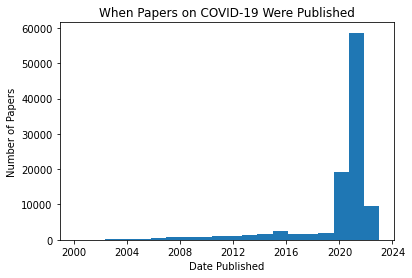

1.8512583487190752


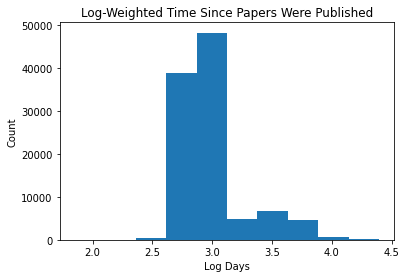

In [4]:
from datetime import datetime
import matplotlib.pyplot as plt
from math import log10

def get_date(date):
    if date.find("-") != -1:
        return datetime.strptime(date, "%Y-%m-%d")
    else:
        return datetime.strptime(date, "%Y")

# Time Created Histogram
publish_times = data['publish_time'].apply(get_date)
publish_times = publish_times[publish_times > datetime.strptime("2000-1-1", "%Y-%m-%d")]
plt.hist(publish_times, bins=20)
plt.title("When Papers on COVID-19 Were Published")
plt.xlabel("Date Published")
plt.ylabel("Number of Papers")
plt.savefig('paper_ages.png')
plt.show()

# Gets the paper age in some number of units

# Note: This should really a datetime object that represents the number of days
data['days'] = data['publish_time'].apply(lambda publish_date: (datetime(2022, 3, 11) - get_date(publish_date)).days + 365)
data['log_days'] = data['days'].apply(lambda x: log10(x + 1))
print(data['log_days'].min())
plt.hist(data['log_days'])
plt.title("Log-Weighted Time Since Papers Were Published")
plt.xlabel("Log Days")
plt.ylabel("Count")
plt.savefig("log_days.png")
plt.show()

In [5]:
# Comparing the length of abstracts to the length of titles to determine compute time
abstract_char_count = data['abstract'].apply(len).sum()
title_char_count = data['title'].apply(len).sum()

print(f"abstracts are {abstract_char_count / title_char_count:10.2f}x larger")

abstracts are      14.22x larger


# Impact Data and Analysis
Here, I am trying to learn more about what kind of impact these papers have and their distributions. Pending these results, I will consider splitting my analysis between high and low impact papers. Additionally, I need to linearize this data regardless.

In [6]:
# Gets a list of API Calls to make (will be joined back up later)
def get_request(doi): 
    return f"https://api.altmetric.com/v1/doi/{doi}"
    
calls = data['doi'].apply(lambda doi: f"https://api.altmetric.com/v1/doi/{doi}").to_frame()
calls['cord_uid'] = data['cord_uid']  
calls.to_csv('altmetric_calls.csv', index=False)
del calls

In [7]:
INC_THRESH = 0.5
cited_by = ['score', 'cord_uid', 'patents', 'posts', 'wikipedia', 'feeds', 'msm', 'tweeters', 'policies', 'accounts']
# Reads the impact data generated from alt metric to a file
impact = pd.read_csv('/kaggle/input/impact-data/impact_upload.csv')

# Selects the dat that I want from this
impact = impact[['score', 'cord_uid', 'patents', 'posts', 'wikipedia', 'feeds', 'msm', 'tweeters', 'policies', 'accounts']].fillna(0) # The impact is zero is there is no data!
impact.head()

,score,cord_uid,patents,posts,wikipedia,feeds,msm,tweeters,policies,accounts
0,20.350,hjc2pcgt,0.0,40,0.0,0.0,0.0,27.0,0.0,29
1,1.500,osiyvooy,0.0,2,0.0,0.0,0.0,2.0,0.0,2
2,2.250,e0sfrji8,0.0,4,0.0,0.0,0.0,2.0,0.0,3
3,69.268,79cmcvfi,0.0,78,0.0,3.0,1.0,68.0,0.0,73
4,4.200,5ke2601z,0.0,6,0.0,0.0,0.0,6.0,0.0,6


In [8]:
# Joins the two data frames together
data = data.set_index('cord_uid').join(impact.set_index('cord_uid'))

# Removes NAs for any of the categories in place
data.dropna(subset=['score'], inplace=True) # Gets rid of everything without a full text
data.head()

,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,...,log_days,score,patents,posts,wikipedia,feeds,msm,tweeters,policies,accounts
cord_uid,,,,,,,,,,,,,,,,,,,,,
000tfenb,c890cb0b691543c29b35b5a1351ff8c990739fe2,Medline; PMC,Prevalence and genetic diversity analysis of h...,10.1186/s12985-017-0896-0,PMC5700739,29166910,cc-by,BACKGROUND: More than a decade after the outbr...,2017-11-22,"Liu, Peilin; Shi, Lei; Zhang, Wei; He, Jianan;...",...,3.286905,10.40,0.0,22.0,7.0,0.0,0.0,11.0,0.0,18.0
002yvwhd,f3ecfbd93c1be2ed26edb48c82e23bf1600b502c,Medline; PMC; WHO,SARS-CoV-2 Infection in Dogs and Cats from Sou...,10.3390/v13081453,PMC8402904,34452319,cc-by,Severe acute respiratory syndrome coronavirus ...,2021-07-26,"Klaus, Julia; Zini, Eric; Hartmann, Katrin; Eg...",...,2.773786,3.60,0.0,5.0,0.0,0.0,0.0,5.0,0.0,5.0
003qgdxv,<NA>,Medline,Laparoscopic ventral hernia repair: defining t...,10.1097/sle.0000000000000020,<NA>,24743667,unk,"Between 2004 and June 2011, 181 patients under...",2014,"Al-Harazi, Arwa; Goel, Rajat; Tan, Charles T K...",...,3.525951,1.00,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
004isps9,194ce5eb34841a9d16995cdc6db6c471ed942e3d,PMC,Effect of positive end-expiratory pressure on ...,10.1016/j.bja.2021.07.031,PMC8449633,34507822,no-cc,BACKGROUND: Lung rest has been recommended dur...,2021-09-08,"Araos, Joaquin; Alegria, Leyla; Garcia, Aline;...",...,2.740363,2.35,0.0,5.0,0.0,0.0,0.0,5.0,0.0,5.0
0053p2ji,<NA>,Medline,A laparoscopic approach for removal of ovarian...,10.1186/s12917-018-1658-y,<NA>,30404648,cc-by,BACKGROUND Surgical treatment of ovarian remna...,2018,"van Nimwegen, Sebastiaan A; Van Goethem, Bart;...",...,3.277838,0.50,0.0,2.0,0.0,0.0,0.0,2.0,0.0,2.0


##### Good paper impact data:
- score
- readers_count
- posts
- accounts


# Textual Analysis
1. Remove non-essential words (what, is, a)
2. Turn each remaining word into its root (walking -> walk)
3. Unsupervised learning on each title (going to expand this to abstracts in the future, but it took too long for testing)
4. Apply the machine learning model to turn each sentence to a list of 100 numbers 

Note: a shift to the spacy bio parser will have to take place to actually read this information

In [9]:
# Language detection
!pip install langdetect
from langdetect import detect
from langdetect import DetectorFactory

from os import cpu_count

# Set the seed
DetectorFactory.seed = 1231123123

print("Starting language detection")

failed = 0
def get_language(row):
    """Gets the languages of each paper using fancy machine-learning"""
    try:
        return detect(''.join(row[:min(len(row), 50)]))
    except:
        global failed
        failed += 1
        
        # Defaulting to English is Fairly Safe
        return 'en'
    
#with mp.Pool(cpu_count()) as pool:
#    data['lang'] = pool.map(get_language, data['abstract'].values)


data['lang'] = data['abstract'].progress_apply(get_language)

     |████████████████████████████████| 981 kB 887 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=5710f156a0aea489a3393c352e4595b9d26d7fc3f77cc16583d62954c1b4d772
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
Starting language detection


100%|██████████| 69046/69046 [10:53<00:00, 105.70it/s]


In [10]:
print(f"Length Before {len(data.index):6d}")
# int(data['lang'])

data = data[data['lang'] == 'en']
print(f"Length After  {len(data.index):6d}")
print(f"Failed        {failed:6d}")

Length Before  69046
Length After   66363
Failed             3


In [11]:
#NLP 
null = !pip install spacy
null = !pip install scispacy
null = !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.4.0/en_core_sci_lg-0.4.0.tar.gz

del null
    
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

In [12]:
# data = data.sample(frac=FRAC_DATASET) # Goes down to 60,000 entries (I am super worried about ram wtf!)

In [13]:
import string

punctuations = set(string.punctuation)
stopwords = set(STOP_WORDS)

In [14]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    stopwords.add(w)

In [15]:
print(f"Rows Before: {len(data.index):20d}")
data.dropna(subset=['pdf_json_files'], inplace=True)
print(f"Rows After: {len(data.index):20d}")

import json
import multiprocessing as mp

root_path = '/kaggle/input/CORD-19-research-challenge/'

def get_body_text(row):
    try:
        body_text = []
        
        with open(root_path + row.split('; ')[0], 'r') as f:
            content = json.load(f)
        body_text = []
        
        for entry in content['body_text']:
            body_text.append(entry['text'])

        body_text = '\n'.join(body_text)
        return body_text # Tokenizes the body text in one big go (hopefully faster!!)
    except:
        print('failed')
        return None

def get_numb_files(row): 
    return len(row.split('; '))

# print(f"Avg Number of Files: {data['pdf_json_files'].progress_apply(get_numb_files).mean():14.2f}")

with mp.Pool(cpu_count()) as pool:
    full_text = [item for item in tqdm(pool.imap(get_body_text, data['pdf_json_files'].values), total=len(data.index))]

print(full_text[0][:100])

# Note: This could be made multi-threaded, but it is relatively fast, so why bother?
# full_text = data['pdf_json_files'].progress_apply(get_body_text)

data.to_csv('body_extract.csv', index=False)

print(f"Rows After: {len(data.index):10d}")

Rows Before:                66363
Rows After:                46045


100%|██████████| 46045/46045 [01:56<00:00, 394.13it/s]


Conclusions: The detection rate and epidemic trend of coronaviruses were stable and no obvious fluct
Rows After:      46045


In [16]:
# Removes body texts shorter than their abstracts

# This could not be necessary is I get apply right


#full_text_length = pd.Series(full_text, name="abstract").apply(lambda x: len(str(x))) # I think the name has to be this way..

#print((full_text_length['abstract'] < data['abstract']).sum())

#data = data[full_text_length > data['abstract'].apply(lambda x: len(str(x)))]

In [17]:
# Tries to do some garbage collection
import gc
gc.collect()

import pickle
import scispacy
import time

# Loads the model (not GPU-optimized regardless)
# spacy.prefer_gpu() # Does not actually bottleneck as GPU performance is limited
nlp = spacy.load("en_core_sci_lg")
nlp.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)  
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = ' '.join([ word for word in mytokens if word not in stopwords and word not in punctuations])
    return mytokens

# About 2 per second. REALLY SLOW!
print("Started Text Processing:")
from os import cpu_count
print(f"Number of Cups Being Used: {cpu_count()}")
with mp.Pool(cpu_count()) as pool:  
    data['processed_text'] = list(tqdm(pool.imap(spacy_tokenizer, full_text), total=len(full_text)))
    
# OLD CODE -> Single-threaded
# data['processed_text'] = full_text.progress_apply(spacy_tokenizer) # This will not work in the notebook
print(data['processed_text'][0][:250])

# Dumps the Processed Text
pickle.dump(data['processed_text'].tolist(), open("processed_text.p", "wb"))
data.head()

# Memory Saving Measures
del full_text
del nlp

Started Text Processing:
Number of Cups Being Used: 4


100%|██████████| 46045/46045 [5:18:39<00:00,  2.41it/s]


conclusion detection rate epidemic trend coronaviruse stable obvious fluctuation find detect coronaviruse share conserve gene sequence s rdrp mutant epidemic strain detect suggest continuous monitoring human coronaviruse need cross-border child likel


100%|██████████| 46045/46045 [00:00<00:00, 365308.84it/s]


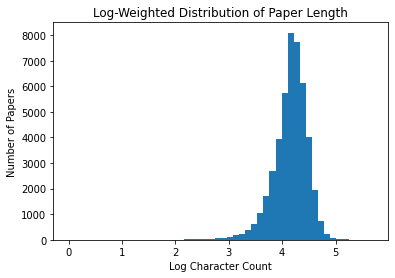

In [18]:
# Makes a histogram of paper length
from math import log10

log_function = log10

paper_length = data['processed_text'].progress_apply(lambda x: log_function(len(x) + 1))

plt.hist(paper_length, bins=50)
plt.title("Log-Weighted Distribution of Paper Length")
plt.xlabel("Log Character Count")
plt.ylabel("Number of Papers")
plt.savefig("PaperLength.png")
plt.show()

del paper_length

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer # Why can't this be integrated with the previous cell
def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

text = data['processed_text'].values
max_features = 2**12

X = vectorize(text, max_features)

import pickle
pickle.dump(X, open('X-first-pickle.p', 'wb'))

# This could remove duplicated values
del text

### Mini EDA of Impact
Trying to linearize the distribution

I am going to take the log of this

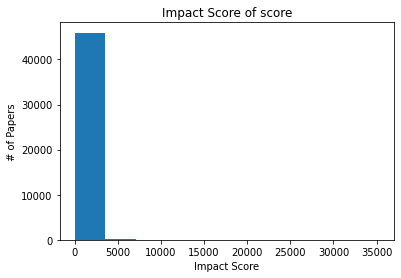

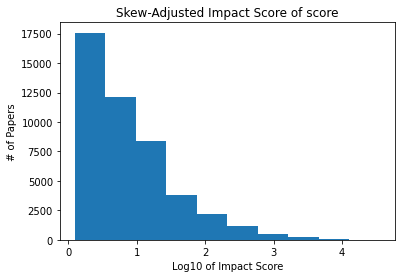

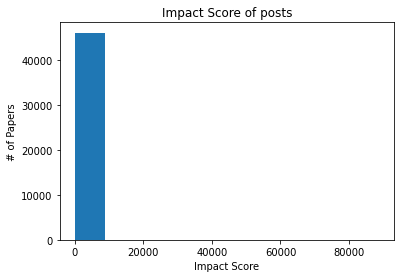

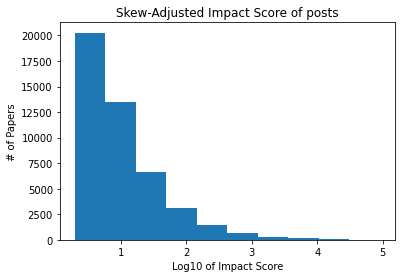

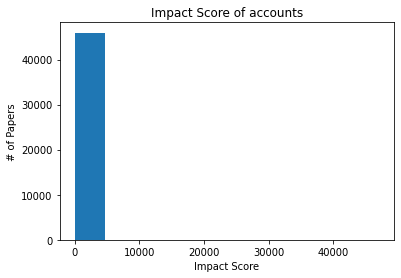

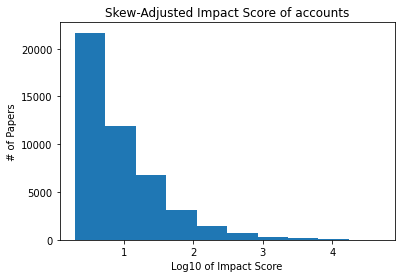

35302.76399998494

In [20]:
import matplotlib.pyplot as plt
import math

# Histograms
for plot_type in ['score', 'posts', 'accounts']:
    # Logs eveythings
    data[plot_type + "_linearized"] = data[plot_type].apply(lambda row: math.log10(row + 1))
    
    plt.hist(data[plot_type])
    plt.title(f"Impact Score of {plot_type}")
    plt.ylabel("# of Papers")
    plt.xlabel("Impact Score")
    plt.savefig(plot_type + ".png")
    plt.show()
    
    plt.hist(data[plot_type + "_linearized"])
    plt.title(f"Skew-Adjusted Impact Score of {plot_type}")
    plt.ylabel("# of Papers")
    plt.xlabel("Log10 of Impact Score")
    plt.savefig(plot_type + "_linearized.png")
    plt.show()
    
data['score'].max()

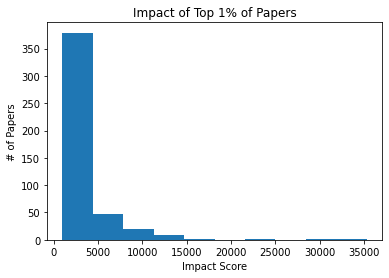

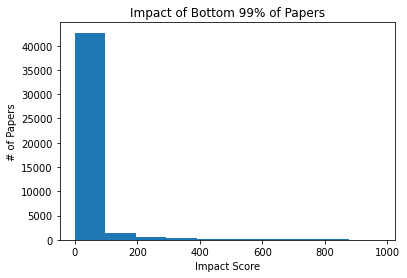

In [21]:
# Score Histogram By Percentile (Not Really Releveant Now)

# Top 1 percentile analysis
top_1 = data['score'].quantile(q=.99, interpolation='linear')

top_1_percent_score = data['score'][data['score'] > top_1]

plt.hist(top_1_percent_score)
plt.ylabel("# of Papers")
plt.xlabel('Impact Score')
plt.title("Impact of Top 1% of Papers")
plt.savefig('top_1_score.png')
plt.show()

# Bottom 99 percentile analysis
bottom_99_percent_score = data['score'][data['score'] < top_1]

plt.hist(bottom_99_percent_score)
plt.ylabel("# of Papers")
plt.xlabel('Impact Score')
plt.title("Impact of Bottom 99% of Papers")
plt.savefig('bottom_99_score.png')
plt.show()

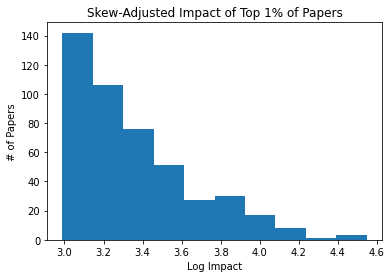

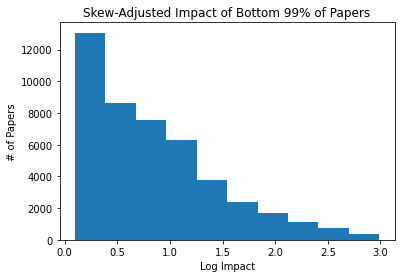

In [22]:
# Linearizing the Score Data
from math import log10

top_1_lin = top_1_percent_score.apply(lambda x: log10(x + 1))

plt.hist(top_1_lin)
plt.title("Skew-Adjusted Impact of Top 1% of Papers")
plt.ylabel("# of Papers")
plt.xlabel("Log Impact")
plt.show()

bottom_99_lin = bottom_99_percent_score.apply(lambda x: log10(x + 1))

plt.hist(bottom_99_lin)
plt.title("Skew-Adjusted Impact of Bottom 99% of Papers")
plt.ylabel("# of Papers")
plt.xlabel("Log Impact")
plt.show()

# Clustering the Dataset 
1. Uses Principle Component Analysis (PCA) to turn 100 columns of data into 3 (enough to be plotted on a 3D dot plot).
2. Uses K-nearest neighbors to group papers based on the closest Euclidan distance
3. 2D Graph of the data
4. 3D graph of the data

In [23]:
# Prepares Textual Data
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced = pca.fit_transform(X.toarray())

print(f"Reduced the dimensions of X by {100 - 100 * X_reduced.shape[1] / X.shape[1]:8.2f} % to {X_reduced.shape[1]}")

Reduced the dimensions of X by    36.35 % to 2607


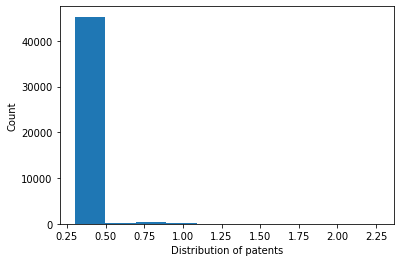

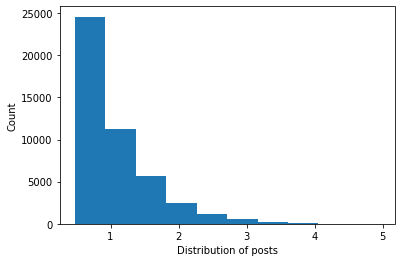

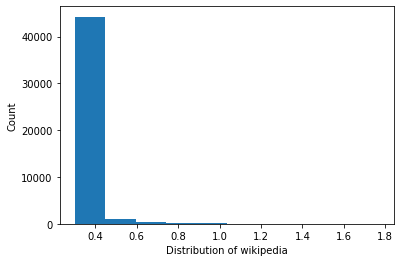

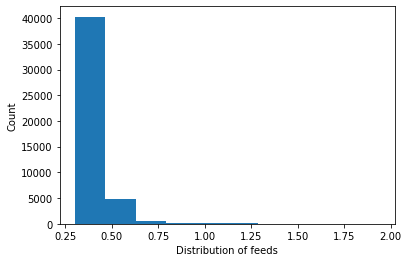

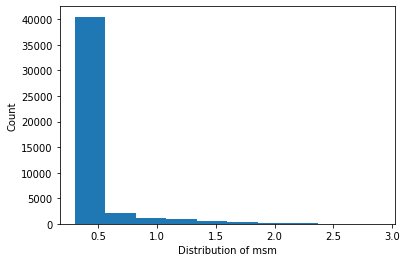

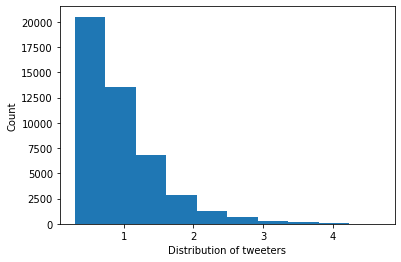

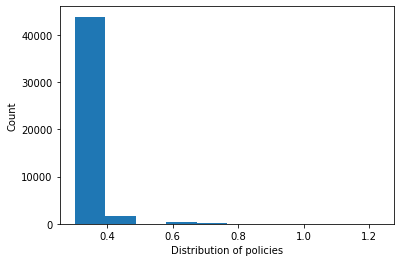

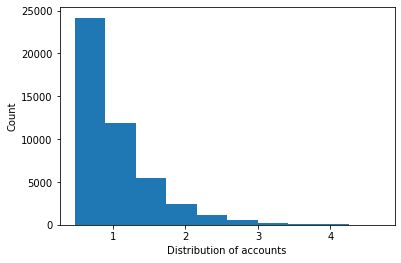

In [24]:
# Prepares the Impact Data Using Linearization
cited_by = ['patents', 'posts', 'wikipedia', 'feeds', 'msm', 'tweeters', 'policies', 'accounts']

import numpy as np
import math

def sigmoid(x):
    """
    This ended up being no good
    """
    return np.where(x < 0, np.exp(x)/(1 + np.exp(x)), 1/(1 + np.exp(-x)))

for citation in cited_by:
    plt.hist(data[citation].apply(lambda x: math.log10(x + 2)))
    plt.xlabel(f"Distribution of {citation}")
    plt.ylabel("Count")
    plt.savefig(f"{citation}.png")
    plt.show()

In [25]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = [i for i in range(2, 30, 4)] # Does clusters in steps of 4 to save time...
for n_clusters in tqdm(K,total=len(K)):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_reduced)
    # k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

100%|██████████| 7/7 [23:21<00:00, 200.18s/it]


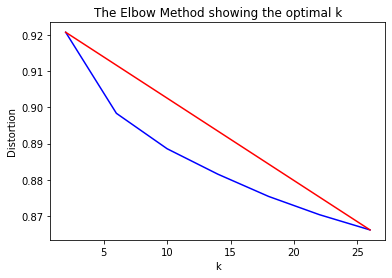

In [26]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.savefig('ElbowMethod.png')
plt.show()

46045


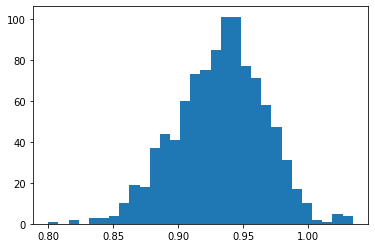

In [27]:
Y_fasdfs = X.copy()
magnitudes = [np.linalg.norm(red) for red in X_reduced]
print(len(magnitudes))
plt.hist(magnitudes[:min(len(magnitudes), 1000)], bins=30)
plt.savefig("reduced_weight.png")
plt.show()

In [28]:
import math

# All of the citations
cited_by = ['patents', 'posts', 'wikipedia', 'feeds', 'msm', 'tweeters', 'policies', 'accounts']
data[cited_by].head()

# The Impact of Each Paper Category
impact_weight = [3, 0.25, 3, 0.25, 8, 0.25, 5, 0.25]

def weight(row):
    return [row[i] * impact_weight[i] for i in range(len(row))]

def linearize(row, *args, **kwargs):
    # Row is a data series
    return [math.log10(x + 2) for x in row]
    
def normalize(row, *args, **kwargs):
    # Normalizes the data to a unit vector
    return pd.Series(row / np.linalg.norm(row))

# Represents the type of impact each paper has
impact_vectors = data[cited_by].apply(weight, axis=1)
impact_vectors = impact_vectors.apply(linearize, axis=1)
impact_vectors = impact_vectors.apply(normalize, axis=1)
impact_vectors = impact_vectors.to_numpy()

# Normalized X-Reduced after the PCA?? IDK if this is necessary

X_reduced = np.apply_along_axis(normalize, 1, X_reduced)

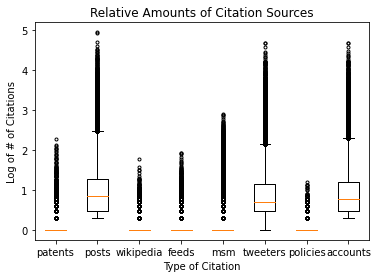

In [29]:
from matplotlib.patches import Polygon
from math import log10

# Makes a multiple box and whisker plot 
fig, ax = plt.subplots()
pos = np.arange(len(data[cited_by])) + 1
bp = ax.boxplot(data[cited_by].apply(lambda x: x.apply(lambda y: log10(y + 1))))

ax.set_xlabel('Type of Citation')
ax.set_ylabel('Log of # of Citations')
ax.set_xticklabels(cited_by)
plt.setp(bp['whiskers'], color='k', linestyle='-')
plt.setp(bp['fliers'], markersize=3.0)
plt.title("Relative Amounts of Citation Sources")
plt.savefig("box_and_whiskers.png")
plt.show()


In [30]:
def combine_impact(textual, impact, p):
    """
    Combines each paper's imapct with their analysis where p is the weight of each category 
    """
    return np.concatenate((np.sqrt(1 - p) * textual, np.sqrt(p) * impact), axis=1)
    

In [31]:
# # Gets the optimal p-value for the percentage of the dataset
# p = [.25 * i for i in range(5)] # [0, 1] -> Error is negative because I am dumb.

# def k_means_score(p, weighted=False):
#     """
#     Gets the Kmeans score for a particular P-value. I do not know why I did not finish this in the first place.
#     """
#     combined_paper = combine_impact(X_reduced, impact_vectors, p)
    
#     kmeans = KMeans(n_clusters=k, random_state=42)
#     if weighted:
#         kmeans.fit(combined_paper, sample_weight=data['score_linearized'])
#         return kmeans.score(combined_paper, sample_weight=data['score_linearized'])
#     kmeans.fit(combined_paper)
#     return kmeans.score(combined_paper)

# k_means_score = list(map(k_means_score, p))

# # Plots the data
# plt.plot(p, k_means_score)
# plt.title("Optimal Weight of Paper's Impact")
# plt.xlabel("Percentage of the Dataset")
# plt.ylabel("K-Means Score")
# plt.savefig("k_means_optimal_score.png")
# plt.show()

In [32]:
# Makes a new Vector
X_reduced = combine_impact(X_reduced, impact_vectors, 0) # This can be a lot higher

# Clusters the thing
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
data['cluster'] = kmeans.fit_predict(X_reduced)
print(kmeans.score(X_reduced))

-40643.70778984159


In [33]:
from sklearn.manifold import TSNE

# TODO: turn up the perplexity for the actual run. Actually, fuck that, low perplexity makes tight clusters, this is a shame, but I do not fucking care.

# The perplexity should be 50 for 200,000, but I am going to use 45 because I am dumb.,..
tsne = TSNE(verbose=1, perplexity=25, n_iter=1000)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 46045 samples in 0.192s...
[t-SNE] Computed neighbors for 46045 samples in 1279.406s...
[t-SNE] Computed conditional probabilities for sample 1000 / 46045
[t-SNE] Computed conditional probabilities for sample 2000 / 46045
[t-SNE] Computed conditional probabilities for sample 3000 / 46045
[t-SNE] Computed conditional probabilities for sample 4000 / 46045
[t-SNE] Computed conditional probabilities for sample 5000 / 46045
[t-SNE] Computed conditional probabilities for sample 6000 / 46045
[t-SNE] Computed conditional probabilities for sample 7000 / 46045
[t-SNE] Computed conditional probabilities for sample 8000 / 46045
[t-SNE] Computed conditional probabilities for sample 9000 / 46045
[t-SNE] Computed conditional probabilities for sample 10000 / 46045
[t-SNE] Computed conditional probabilities for sample 11000 / 46045
[t-SNE] Computed conditional probabilities for sample 12000 / 46045
[t-SNE] Computed conditional probabilities for 

In [34]:
import pickle

data.to_pickle('data_final.p')

pickle.dump(X, open('x.p', 'wb'))
pickle.dump(X_embedded, open('X_embedded.p', 'wb'))
pickle.dump(X_reduced, open('X_reduced.p', 'wb'))

In [35]:
# TODO: Move this up so more of the program can be run...

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import os
import pickle

# Monitors the Status of the Project
from tqdm import tqdm
tqdm.pandas()

if 'data' not in globals():
    # TODO: Replace with a dataset call
    ! wget https://raw.githubusercontent.com/wkaisertexas/COVID-Paper-Clustering/main/data_final.p
    data = pd.read_pickle('data_final.p')
    k = 18 # The test thing used 18

if 'X_embedded' not in globals():
    ! wget https://raw.githubusercontent.com/wkaisertexas/COVID-Paper-Clustering/main/X_embedded.p
    X_embedded = pd.read_pickle('X_embedded.p')


#### Clustering the Data
This is a mid plot, but the real plot will be made later.

# Vectorization
Extracts common keywords from each cluster.

Also, removes a list of keywords common to all.

In [36]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
vectorizers = []
    
for ii in range(0, k):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [37]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        # print(cvec.fit_transform(data.loc[data['cluster'] == current_cluster, 'processed_text']))
        vectorized_data.append(cvec.fit_transform(data.loc[data['cluster'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None) # I need something for the bokeh plots

In [38]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20


lda_models = []

for ii in range(0, k):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)
    
lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)

In [39]:
clusters_lda_data = []

for current_cluster, lda in enumerate(tqdm(lda_models, total=len(lda_models))):   
    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

100%|██████████| 20/20 [45:31<00:00, 136.55s/it]


In [40]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []
    
    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])
                
    keywords.sort(key = lambda x: x[1])  
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [41]:
all_keywords = []
for current_vectorizer, lda in enumerate(tqdm(lda_models)):
    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

100%|██████████| 20/20 [00:16<00:00,  1.21it/s]


In [42]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

Keywords: sars-cov- ace treatment drug covid- endothelial pathway case vitamin analysis mouse ifn effect platelet group tlr day expression stat lung respiratory inflammation brain obesity msc type inflammasome sepsis cardiac heart receptor cns myocardial bacterial crs eosinophil pregnancy stem psoriasis skin aged reserve author ibd fungal mucormycosis ruxolitinib eosinophilic granule arteritis dub ubiquitin usp mucorale

Number of Words in the Categories        546


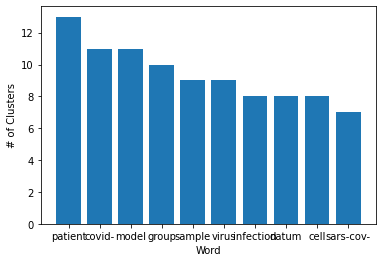

In [43]:
print("Keywords:", *all_keywords[0])

massive_all_keywords = []

for keywords in all_keywords:
    massive_all_keywords += keywords

keyword_count = {}
for keyword in massive_all_keywords:
    if keyword in keyword_count:
        keyword_count[keyword] += 1
    else:
        keyword_count[keyword] = 1
keyword_count = dict(sorted(keyword_count.items(), key=lambda item: item[1], reverse=True))

print(f"\nNumber of Words in the Categories {len(list(set(massive_all_keywords))):10d}")

n_bars = min(10, len(keyword_count.keys()))

plt.bar([i for i in range(n_bars)], list(keyword_count.values())[:n_bars], tick_label=list(keyword_count.keys())[:n_bars])
plt.xlabel("Word")
plt.ylabel("# of Clusters")
plt.savefig("category.png")
plt.show()

while len(all_keywords) < k: # so the bokeh plot does not break at small numbers
    all_keywords.append([])

# Plotting
This was nearly directly copied from Maksim Ekin. I had no idea how to use Bokeh before this, but I modified the code to include each papers impact in various scientific fields.

So, I want to only display the sources where the paper has citations, so I am going to pre-generate a text file for citations.

This text file will have multiple lines, but it will only contain the necessary stuff. I am just going to override data['score'] for this, and I know this is super hacky, but it is something that I have to do.

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


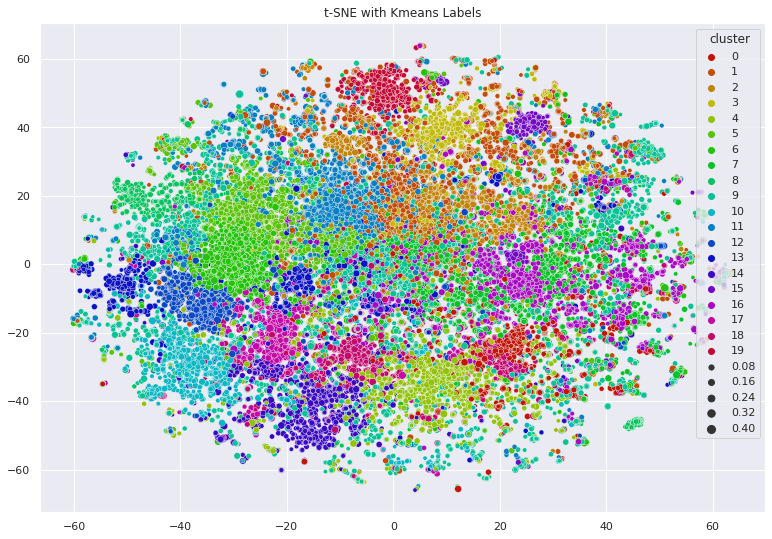

In [44]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# Note: the size of each dot will be the log weighted impact divided by the score.

# plot

data['_'] = data['score_linearized'] / 10

sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=data['cluster'], legend='brief', size=data['_'],palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

# Bokeh

In [45]:
# NoteL I replaced my version of the script with the new one!
! wget https://raw.githubusercontent.com/wkaisertexas/COVID-Paper-Clustering/main/plot_text.py
! wget https://raw.githubusercontent.com/wkaisertexas/COVID-Paper-Clustering/main/call_backs.py
! mkdir library
! mv plot_text.py library/.
! mv call_backs.py library/.
! touch library/__init__.py
! ls library/

--2022-03-25 06:50:10--  https://raw.githubusercontent.com/wkaisertexas/COVID-Paper-Clustering/main/plot_text.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5703 (5.6K) [text/plain]
Saving to: ‘plot_text.py’

plot_text.py        100%[===================>]   5.57K  --.-KB/s    in 0s      

2022-03-25 06:50:10 (27.6 MB/s) - ‘plot_text.py’ saved [5703/5703]

--2022-03-25 06:50:11--  https://raw.githubusercontent.com/wkaisertexas/COVID-Paper-Clustering/main/call_backs.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3270 (3.2K) 

In [46]:
# required libraries for plot
from library.plot_text import header, description, description2, cite, description_search, description_slider, notes, dataset_description, toolbox_header 
from library.call_backs import input_callback, selected_code
import bokeh
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper, CustomJS, Slider, TapTool, TextInput
from bokeh.palettes import Category20
from bokeh.transform import linear_cmap, transform
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import RadioButtonGroup, TextInput, Div, Paragraph
from bokeh.layouts import column, widgetbox, row, layout
from bokeh.layouts import column

In [47]:
import os

topic_path = os.path.join(os.getcwd(), 'topics.txt')
with open(topic_path) as f:
    topics = f.readlines()

In [48]:
# show on notebook
output_notebook()

# Trying to fix it getting mad at me for null values
print(data.isna().sum())
data.fillna("", inplace=True)

# target labels
y_labels = data['cluster'].values

# data sources
source = ColumnDataSource(data=dict(
    x= X_embedded[:,0], 
    y= X_embedded[:,1],
    x_backup = X_embedded[:,0],
    y_backup = X_embedded[:,1],
    desc= y_labels, 
    titles= data['title'].values,
    authors = data['authors'].values,
    journal = data['journal'].values,
    abstract = data['abstract'].values,
    labels = ["C-" + str(x) for x in y_labels],
    links = data['doi'].values,
    impact = data['score'].apply(lambda r: round(r, 2)).values,
    size = data['score_linearized'].apply(lambda x: x * 2 + 2).values
    ))

# hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links"),
    ("Impact", "@impact") # Impact from many different categories should be included
],
point_policy="follow_mouse")

# map colors
mapper = linear_cmap(field_name='desc', 
                     palette=Category20[20],
                     low=min(y_labels) ,high=max(y_labels))

# prepare the figure
plot = figure(plot_width=1000, plot_height=850, 
           tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'], 
           title="Clustering of the COVID-19 Literature with t-SNE and K-Means", 
           toolbar_location="above", output_backend="webgl")

# plot settings
plot.scatter('x', 'y', size='size', 
          source=source,
          fill_color=mapper,
          line_alpha=0.3,
          line_color="black",
          legend = 'labels')
plot.legend.background_fill_alpha = 0.6
plot.title = "Impact Clustering"

Loading BokehJS ...

sha                        0
source_x                   0
title                      0
doi                        0
pmcid                   5011
pubmed_id               7363
license                    0
abstract                   0
publish_time               0
authors                   94
journal                 3761
mag_id                 46045
who_covidence_id       46045
arxiv_id               45747
pdf_json_files             0
pmc_json_files          8394
url                        0
s2_id                   5073
days                       0
log_days                   0
score                      0
patents                    0
posts                      0
wikipedia                  0
feeds                      0
msm                        0
tweeters                   0
policies                   0
accounts                   0
lang                       0
processed_text             0
score_linearized           0
posts_linearized           0
accounts_linearized        0
cluster       

In [49]:
# Keywords
text_banner = Paragraph(text= 'Keywords: Slide to specific cluster to see the keywords.', height=25)
input_callback_1 = input_callback(plot, source, text_banner, topics)

# currently selected article
div_curr = Div(text="""Click on a plot to see the link to the article.""",height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# WIDGETS
slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #")
keyword = TextInput(title="Search:")

# pass call back arguments
# input_callback_1.args["text"] = keyword
# input_callback_1.args["slider"] = slider

slider.js_on_event('value', input_callback_1)
keyword.js_on_event('value', input_callback_1)


In [50]:
# STYLE
header.sizing_mode = "stretch_width"
header.style={'color': '#2e484c', 'font-family': 'Julius Sans One, sans-serif;'}
header.margin=5

description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description.sizing_mode = "stretch_width"
description.margin = 5

description2.sizing_mode = "stretch_width"
description2.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description2.margin=10

description_slider.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_slider.sizing_mode = "stretch_width"

description_search.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
description_search.sizing_mode = "stretch_width"
description_search.margin = 5

slider.sizing_mode = "stretch_width"
slider.margin=15

keyword.sizing_mode = "scale_both"
keyword.margin=15

div_curr.style={'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
div_curr.sizing_mode = "scale_both"
div_curr.margin = 20

text_banner.style={'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.sizing_mode = "stretch_width"
text_banner.margin = 20

plot.sizing_mode = "scale_both"
plot.margin = 40

dataset_description.sizing_mode = "stretch_width"
dataset_description.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
dataset_description.margin=10

notes.sizing_mode = "stretch_width"
notes.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
notes.margin=10

cite.sizing_mode = "stretch_width"
cite.style ={'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
cite.margin=10

r = row(div_curr,text_banner)
r.sizing_mode = "stretch_width"

In [51]:
# LAYOUT OF THE PAGE ( this is so messed up)
l = layout([
    [header],
    [description],
    [description_slider, description_search],
    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot],
    [description2, dataset_description, notes, cite],
])
l.sizing_mode = "scale_both"


# show
output_file('t-sne_covid-19_interactive.html')
save(l)

'/kaggle/working/t-sne_covid-19_interactive.html'

## Conclusion
    All in all, it was found that there was high correlation between each clusters, as well as a good corelation between impact and cluster size.